<a href="https://colab.research.google.com/github/chltjs1921/2024_modeling_practice/blob/main/11_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ref: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/09_pytorch_model_deployment.ipynb  
https://www.learnpytorch.io/09_pytorch_model_deployment/

In [76]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.4.1+cu121
torchvision version: 0.19.1+cu121


In [77]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [78]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [79]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [80]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

In [81]:
from torchvision.models import EfficientNet_B2_Weights, efficientnet_b2

effnetB2weights = EfficientNet_B2_Weights.DEFAULT
effnetB2transforms = effnetB2weights.transforms()
effnetB2 = efficientnet_b2(weights=effnetB2weights).to(device)

In [82]:
for param in effnetB2.features.parameters():
    param.requires_grad = False

In [83]:
from torchinfo import summary

summary(effnetB2, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224] [1, 1000]       --              Partial
├─Sequential (features)                                      [1, 3, 224, 224] [1, 1408, 7, 7] --              False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224] [1, 32, 112, 112] --              False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224] [1, 32, 112, 112] (864)           False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112] [1, 32, 112, 112] (64)            False
│    │    └─SiLU (2)                                         [1, 32, 112, 112] [1, 32, 112, 112] --              --
│    └─Sequential (1)                                        [1, 32, 112, 112] [1, 16, 112, 112] --              False
│    │    └─MBConv (0)                                   

In [84]:
set_seeds(42)

effnetB2.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
).to(device)

In [85]:
from torchinfo import summary

summary(effnetB2, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=10, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape Output Shape Param #    Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224] [1, 3]     --         Partial
├─Sequential (features)                                      [1, 3, 224, 224] [1, 1408, 7, 7] --         False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224] [1, 32, 112, 112] --         False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224] [1, 32, 112, 112] (864)      False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112] [1, 32, 112, 112] (64)       False
│    │    └─SiLU (2)                                         [1, 32, 112, 112] [1, 32, 112, 112] --         --
│    └─Sequential (1)                                        [1, 32, 112, 112] [1, 16, 112, 112] --         False
│    │    └─MBConv (0)                                       [1, 32, 112, 112] [1, 16, 112, 112] (1,448)    F

In [86]:
def create_effnetb2_model(num_classes:int=3):
    effnetB2weights = EfficientNet_B2_Weights.DEFAULT
    effnetB2transforms = effnetB2weights.transforms()
    effnetB2 = efficientnet_b2(weights=effnetB2weights)
    for param in effnetB2.features.parameters():
        param.requires_grad = False
    effnetB2.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes, bias=True)
    )
    return effnetB2, effnetB2transforms

In [87]:
effnetB2, effnetB2_transforms = create_effnetb2_model(num_classes=3)

In [88]:
effnetB2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [89]:
from torchinfo import summary

summary(effnetB2, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224] [1, 3]          --              Partial
├─Sequential (features)                                      [1, 3, 224, 224] [1, 1408, 7, 7] --              False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224] [1, 32, 112, 112] --              False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224] [1, 32, 112, 112] (864)           False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112] [1, 32, 112, 112] (64)            False
│    │    └─SiLU (2)                                         [1, 32, 112, 112] [1, 32, 112, 112] --              --
│    └─Sequential (1)                                        [1, 32, 112, 112] [1, 16, 112, 112] --              False
│    │    └─MBConv (0)                                   

In [90]:
from going_modular.going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetB2_transforms,
    batch_size=32
)

In [91]:
len(train_dataloader), len(test_dataloader), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [92]:
from going_modular.going_modular import engine

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effnetB2.parameters(), lr=0.001)

set_seeds(42)
effnetB2_results = engine.train(model=effnetB2,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9583 | train_acc: 0.6042 | test_loss: 0.7250 | test_acc: 0.9352
Epoch: 2 | train_loss: 0.6802 | train_acc: 0.8583 | test_loss: 0.5771 | test_acc: 0.9131
Epoch: 3 | train_loss: 0.5668 | train_acc: 0.8833 | test_loss: 0.4837 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4334 | train_acc: 0.9000 | test_loss: 0.4250 | test_acc: 0.9381
Epoch: 5 | train_loss: 0.4077 | train_acc: 0.9104 | test_loss: 0.3876 | test_acc: 0.9381
Epoch: 6 | train_loss: 0.4171 | train_acc: 0.8958 | test_loss: 0.3462 | test_acc: 0.9750
Epoch: 7 | train_loss: 0.4129 | train_acc: 0.8708 | test_loss: 0.3225 | test_acc: 0.9472
Epoch: 8 | train_loss: 0.3851 | train_acc: 0.9062 | test_loss: 0.3413 | test_acc: 0.9352
Epoch: 9 | train_loss: 0.3746 | train_acc: 0.8958 | test_loss: 0.3077 | test_acc: 0.9256
Epoch: 10 | train_loss: 0.3506 | train_acc: 0.8729 | test_loss: 0.2770 | test_acc: 0.9688


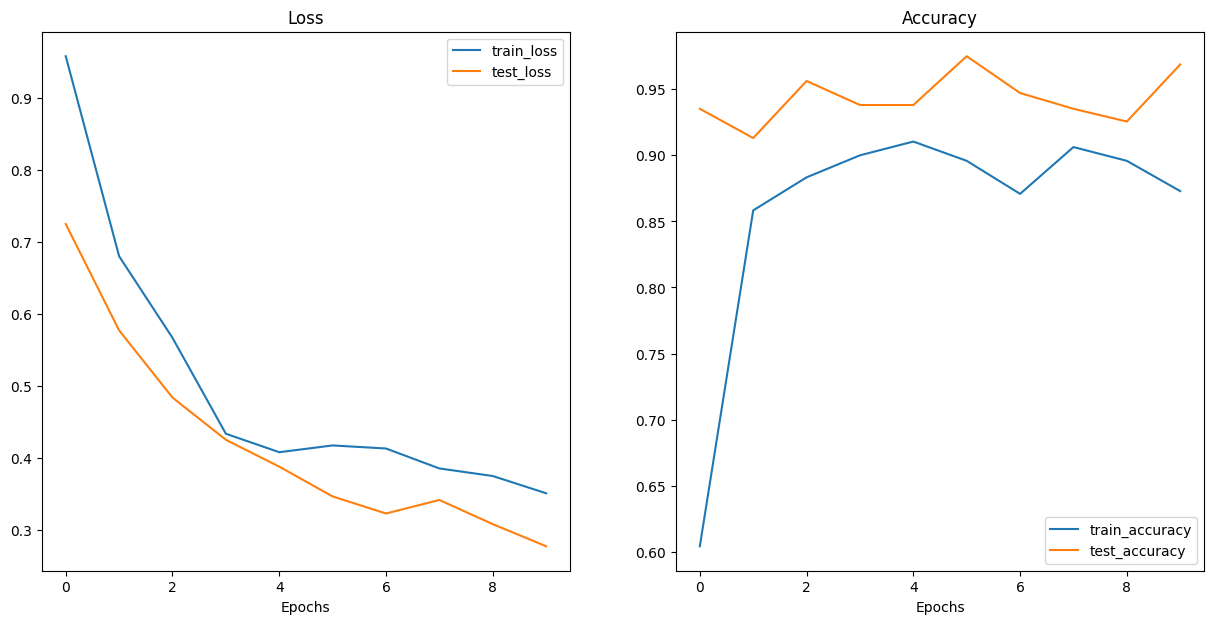

In [93]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetB2_results)

In [94]:
from going_modular.going_modular import utils

utils.save_model(model=effnetB2,
                 target_dir="models",
                 model_name="effnetB2_model.pth")

[INFO] Saving model to: models/effnetB2_model.pth


In [95]:
from pathlib import Path

model_path = Path("models/effnetB2_model.pth")
loaded_effnetB2_size = model_path.stat().st_size / (1024 * 1024)
loaded_effnetB2_size # MB 단위

29.8286075592041

In [96]:
effnetB2_total_params = sum(p.numel() for p in effnetB2.parameters())
effnetB2_total_params

7705221

In [97]:
effnetB2_stats = {"test_loss": effnetB2_results['test_loss'][-1],
                  "test_acc": effnetB2_results['test_acc'][-1],
                  "model_size (MB)": loaded_effnetB2_size,
                  "model_params": effnetB2_total_params}

In [98]:
effnetB2_stats

{'test_loss': 0.27697635591030123,
 'test_acc': 0.96875,
 'model_size (MB)': 29.8286075592041,
 'model_params': 7705221}

In [99]:
import torchvision

vitb16model = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT)

In [100]:
def create_vitb16_model(num_classes:int=3):
    vitb16transforms = torchvision.models.ViT_B_16_Weights.DEFAULT.transforms()
    vitb16model = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT)
    for param in vitb16model.parameters():
        param.requires_grad = False
    vitb16model.heads = nn.Sequential(
        nn.Linear(in_features=768, out_features=num_classes, bias=True)
    )
    return vitb16model, vitb16transforms

In [101]:
vitb16model, vitb16transforms = create_vitb16_model()

In [102]:
from torchinfo import summary

summary(vitb16model, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 3]          768             Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         False
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]

In [103]:
from going_modular.going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names_vit = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vitb16transforms,
    batch_size=32
)

In [104]:
len(train_dataloader_vit), len(test_dataloader_vit), class_names_vit

(15, 5, ['pizza', 'steak', 'sushi'])

In [105]:
from going_modular.going_modular import engine

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vitb16model.parameters(), lr=0.001)

set_seeds(42)
vitb16model_results = engine.train(model=vitb16model,
                                train_dataloader=train_dataloader_vit,
                                test_dataloader=test_dataloader_vit,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5992 | train_acc: 0.8292 | test_loss: 0.2066 | test_acc: 0.9750
Epoch: 2 | train_loss: 0.2354 | train_acc: 0.9250 | test_loss: 0.1282 | test_acc: 0.9875
Epoch: 3 | train_loss: 0.1634 | train_acc: 0.9625 | test_loss: 0.0999 | test_acc: 0.9875
Epoch: 4 | train_loss: 0.1165 | train_acc: 0.9646 | test_loss: 0.0863 | test_acc: 0.9875
Epoch: 5 | train_loss: 0.1055 | train_acc: 0.9688 | test_loss: 0.0766 | test_acc: 0.9812
Epoch: 6 | train_loss: 0.1170 | train_acc: 0.9458 | test_loss: 0.0699 | test_acc: 0.9875
Epoch: 7 | train_loss: 0.0829 | train_acc: 0.9792 | test_loss: 0.0750 | test_acc: 0.9812
Epoch: 8 | train_loss: 0.0856 | train_acc: 0.9875 | test_loss: 0.0648 | test_acc: 0.9875
Epoch: 9 | train_loss: 0.0865 | train_acc: 0.9854 | test_loss: 0.0610 | test_acc: 0.9875
Epoch: 10 | train_loss: 0.0605 | train_acc: 0.9854 | test_loss: 0.0578 | test_acc: 0.9875


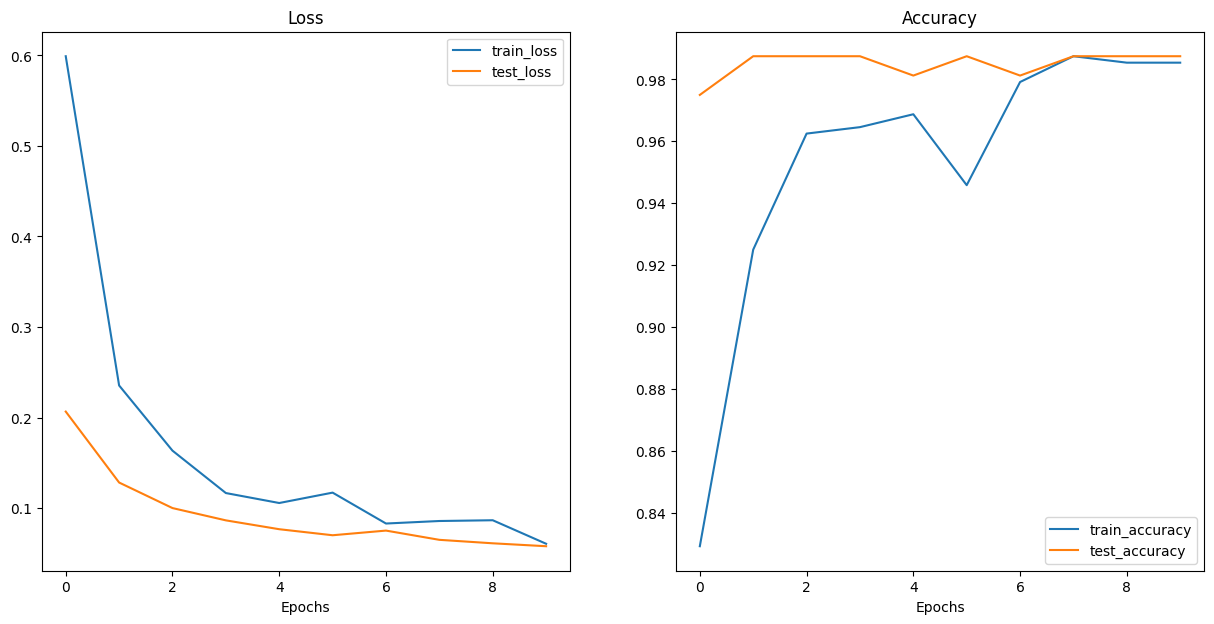

In [106]:
plot_loss_curves(vitb16model_results)

In [107]:
utils.save_model(model=vitb16model,
                 target_dir="models",
                 model_name="vitb16_model.pth")

[INFO] Saving model to: models/vitb16_model.pth


In [108]:
vitb16model_path = Path("models/vitb16_model.pth")
loaded_vitb16model_size = vitb16model_path.stat().st_size / (1024 * 1024)
loaded_vitb16model_size # MB 단위

327.3629894256592

In [109]:
vitb16model_total_params = sum(p.numel() for p in vitb16model.parameters())
vitb16model_total_params

85800963

In [110]:
vitb16_stats = {"test_loss": vitb16model_results['test_loss'][-1],
                  "test_acc": vitb16model_results['test_acc'][-1],
                  "model_size (MB)": loaded_vitb16model_size,
                  "model_params": vitb16model_total_params}
vitb16_stats

{'test_loss': 0.05777871697209776,
 'test_acc': 0.9875,
 'model_size (MB)': 327.3629894256592,
 'model_params': 85800963}

In [111]:
from pathlib import Path

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1687143.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1555015.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/648055.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3375083.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/416067.jpg')]

In [112]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
    pred_list = []

    for path in tqdm(paths):
        pred_dict = {}

        pred_dict['inage_path'] = path
        class_name = path.parent.stem
        pred_dict['actual_class'] = class_name

        start_time = timer()
        img = Image.open(path)
        img = transform(img).unsqueeze(dim=0).to(device)
        model.to(device)
        model.eval()
        with torch.inference_mode():
            pred_logits = model(img)
            pred_prob = torch.softmax(pred_logits, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_dict['predicted_class'] = class_names[pred_label.cpu()]
            pred_dict['pred_prob'] = pred_prob.unsqueeze(0).max().cpu().item()
            end_time = timer()
            pred_dict['inference_time'] = round(end_time - start_time, 3)

        pred_dict['correct'] = pred_dict['actual_class'] == pred_dict['predicted_class']
        pred_list.append(pred_dict)
    return pred_list

In [113]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetB2,
                                          transform=effnetB2_transforms,
                                          class_names=class_names,
                                          device=device)

  0%|          | 0/150 [00:00<?, ?it/s]

In [114]:
effnetb2_test_pred_dicts

[{'inage_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1687143.jpg'),
  'actual_class': 'pizza',
  'predicted_class': 'pizza',
  'pred_prob': 0.9276300668716431,
  'inference_time': 0.033,
  'correct': True},
 {'inage_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1555015.jpg'),
  'actual_class': 'pizza',
  'predicted_class': 'pizza',
  'pred_prob': 0.9657992720603943,
  'inference_time': 0.025,
  'correct': True},
 {'inage_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/648055.jpg'),
  'actual_class': 'pizza',
  'predicted_class': 'pizza',
  'pred_prob': 0.7938627004623413,
  'inference_time': 0.026,
  'correct': True},
 {'inage_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3375083.jpg'),
  'actual_class': 'pizza',
  'predicted_class': 'pizza',
  'pred_prob': 0.8345844149589539,
  'inference_time': 0.026,
  'correct': True},
 {'inage_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/416067.jpg'),
  'actual_c

In [115]:
import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,inage_path,actual_class,predicted_class,pred_prob,inference_time,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.927630,0.033,True
1,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.965799,0.025,True
2,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,pizza,0.793863,0.026,True
3,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,pizza,0.834584,0.026,True
4,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,pizza,0.970335,0.026,True


In [116]:
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,145
False,5


In [117]:
effnetb2_average_time_per_pred = effnetb2_test_pred_df.inference_time.mean()
effnetb2_average_time_per_pred

0.02331333333333333

In [118]:
vitb16_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=vitb16model,
                                          transform=vitb16transforms,
                                          class_names=class_names,
                                          device=device)

  0%|          | 0/150 [00:00<?, ?it/s]

In [119]:
vitb16_test_pred_df = pd.DataFrame(vitb16_test_pred_dicts)
vitb16_test_pred_df.head()

,inage_path,actual_class,predicted_class,pred_prob,inference_time,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.999140,0.030,True
1,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.998067,0.028,True
2,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,pizza,0.998051,0.028,True
3,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,pizza,0.998489,0.028,True
4,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,pizza,0.993425,0.029,True


In [120]:
vitb16_test_pred_df.correct.value_counts()

,count
correct,
True,148
False,2


In [121]:
vitb16_average_time_per_pred = vitb16_test_pred_df.inference_time.mean()
vitb16_average_time_per_pred

0.01967333333333333

In [122]:
vitb16_stats['time_per_pred'] = vitb16_average_time_per_pred
effnetB2_stats['time_per_pred'] = effnetb2_average_time_per_pred

In [123]:
df = pd.DataFrame([effnetB2_stats, vitb16_stats])
df['model'] = ['effnetB2', 'vitb16']
df['test_acc'] = df['test_acc'] * 100
df

,test_loss,test_acc,model_size (MB),model_params,time_per_pred,model
0,0.276976,96.875,29.828608,7705221,0.023313,effnetB2
1,0.057779,98.750,327.362989,85800963,0.019673,vitb16


In [124]:
pd.DataFrame(data=df.set_index('model').loc['vitb16'] / df.set_index('model').loc['effnetB2'],
             columns=['vitb16 to effnetB2 ratios']).T


,test_loss,test_acc,model_size (MB),model_params,time_per_pred
vitb16 to effnetB2 ratios,0.208605,1.019355,10.9748,11.135432,0.843866


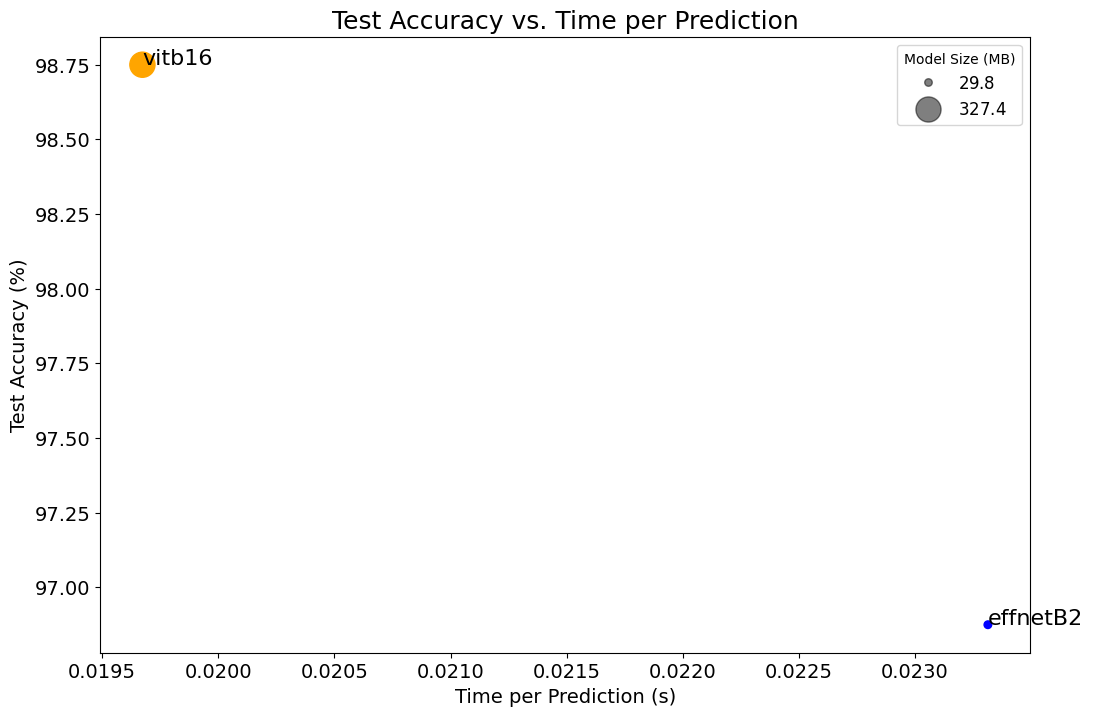

In [125]:
fig, ax = plt.subplots(figsize=(12,8))
scatter = ax.scatter(data=df, x = 'time_per_pred', y='test_acc', c=['blue', 'orange'], s='model_size (MB)')
ax.set_xlabel('Time per Prediction (s)', fontsize=14)
ax.set_ylabel('Test Accuracy (%)', fontsize=14)
ax.set_title('Test Accuracy vs. Time per Prediction', fontsize=18)
ax.tick_params(axis='both', labelsize=14)

for index, text in enumerate(df['model']):
    ax.annotate(text, (df['time_per_pred'][index], df['test_acc'][index]), fontsize=16)

handles, labels = scatter.legend_elements(prop='sizes', alpha=0.5)
model_size_legend = ax.legend(handles, labels, loc='upper right', title='Model Size (MB)', fontsize=12)

In [126]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 14.1 MB/s eta 0:00:00


In [127]:
import gradio as gr

effnetB2.to('cpu')

next(iter(effnetB2.parameters())).device

device(type='cpu')

In [131]:
from typing import Tuple, Dict

def predict_img(img) -> Tuple[Dict, float]:
    start_time = timer()
    img = effnetB2_transforms(img).unsqueeze(0)
    model = effnetB2
    model.eval()
    with torch.inference_mode():
        pred_logits = model(img)
        pred_prob = torch.softmax(pred_logits, dim=1)
    pred_labels_and_probs = {class_names[i]: float(pred_prob[0][i]) for i in range(len(class_names))}
    pred_time = round(timer() - start_time, 5)
    return pred_labels_and_probs, pred_time

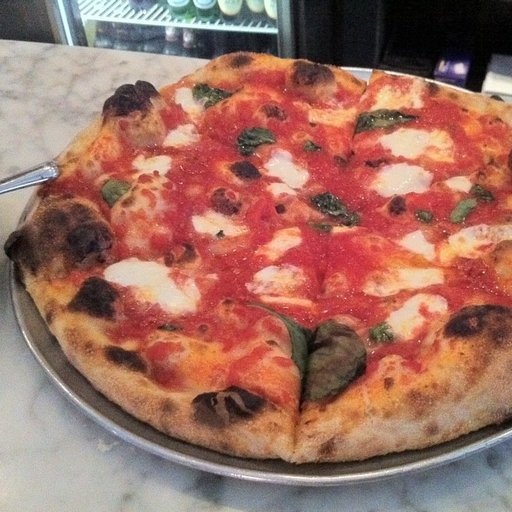

In [134]:
import random
from PIL import Image

img_path = random.choice(test_data_paths)
img = Image.open(img_path)
img

In [135]:
pred_labels_and_probs, pred_time = predict_img(img)
pred_labels_and_probs, pred_time

({'pizza': 0.9874384999275208,
  'steak': 0.0050686560571193695,
  'sushi': 0.007492867764085531},
 0.05985)

In [136]:
import gradio as gr

example_list = [str(filepath) for filepath in random.sample(test_data_paths, k=3)]
example_list

['data/pizza_steak_sushi_20_percent/test/sushi/389730.jpg',
 'data/pizza_steak_sushi_20_percent/test/steak/730464.jpg',
 'data/pizza_steak_sushi_20_percent/test/pizza/3375083.jpg']

In [138]:
gr.Interface(fn=predict_img,
             inputs=gr.Image(type='pil'),
             outputs=[gr.Label(num_top_classes=3, label='Predictions'),
                      gr.Number(label='Prediction Time (s)')],
             examples=example_list).launch(debug=False)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2f066e828e4d61e3d8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
